References:
- [Spacecraft attitude determination methods in an educational context](http://kth.diva-portal.org/smash/get/diva2:1380173/FULLTEXT01.pdf)
- [Characteristic polynomial of the QUEST algorithm](https://ieeexplore.ieee.org/document/5512178)
- [Attitude Estimation: With or Without Spacecraft Dynamics?](https://ntrs.nasa.gov/api/citations/20190027476/downloads/20190027476.pdf)
- [Chapter 4 - Attitude Determination](http://www.dept.aoe.vt.edu/~cdhall/courses/aoe4140/attde.pdf)

In [1]:
using LinearAlgebra, StatsPlots, Random, Plots, PlotThemes, BenchmarkTools, Statistics, Distributions

In [2]:
# helper functions
include("C:/Users/mjski/Desktop/Active-Work/git-projects/scripts/scripts/spacecraft_adcs.jl")

function dcm_deviation(C, C_true)
    CN = C * C_true'
    return acos(0.5 * (CN[1,1] + CN[2,2] + CN[3,3] - 1))
end

dcm_deviation (generic function with 1 method)

# Method Algorithms

In [7]:
function quest_method(nv1, nv2, Bv1, Bv2; iter=5, w = [1, 1]) 
    B = w[1] * Bv1 * nv1' + w[2] * Bv2 * nv2'
    
    S = B + B'
    
    σ = trace(B)
    
    Z = [
        B[2,3] - B[3,2]
        B[3,1] - B[1,3]
        B[1,2] - B[2,1]
    ]
    
    K = [
        S-σ*I(3) Z
        Z' σ
    ]
    
    λ = [sum(w), sum(w), sum(w), sum(w)]
    
    coeff = [
        σ^2 - trace(adjoint(S))
        σ^2 + Z' * Z
        8*det(B)
        Z' * S * S * Z
    ]

    function _poly(λ, coeffs, σ)
        a, b, c, d = coeffs
        # factored form
        return (λ.^2 .- a) .* (λ.^2 .- b) .- c.*λ .+ (c*σ - d)
        #return λ.^4 .- (a + b) .* λ.^2 .- c .* λ .+ (a*b + c*σ - d) 
    end

    function _poly_prime(λ, coeffs, σ)
        a, b, c, d = coeffs
        # derivative of expanded form wrt. λ
        return 4 .* λ .^3 .- 2*(a + b) .* λ .- c
    end

    for i in 1:iter
        λ = λ - _poly(λ, coeff, σ) ./ _poly_prime(λ, coeff, σ)
    end
    
    λmax = maximum(λ)
    p = inv((λmax + σ)*I(3) - S) * Z
    
    q̄ = (1 / sqrt(1 + p' * p)) * [
        p
        1
    ]
    
    return q̄
end

quest_method (generic function with 1 method)

In [4]:
function olae_method(nv1, nv2, Bv1, Bv2)
    d = [
        Bv1 - nv1
        Bv2 - nv2
    ]
    
    S = [
        cross_mat(Bv1 + nv1)
        cross_mat(Bv2 + nv2)
    ]
    
    W = [
        I(3) zeros(3,3)
        zeros(3,3) I(3)
    ]
    
    p = inv(S' * W * S) * S' * W * d
    
    q̄ = (1 / sqrt(1 + p' * p)) * [
        p
        1
    ]
    
    return q̄
end

olae_method (generic function with 1 method)

In [5]:
function triad_method(nv1, nv2, Bv1, Bv2)
    Bt1 = Bv1
    Bt2 = cross(Bv1, Bv2) / norm(cross(Bv1, Bv2))
    Bt3 = cross(Bt1, Bt2)
    
    nt1 = nv1
    nt2 = cross(nv1, nv2) / norm(cross(nv1, nv2))
    nt3 = cross(nt1, nt2)
    
    C_BT = [Bt1 Bt2 Bt3]
    C_NT = [nt1 nt2 nt3]
    
    C_BN = C_BT * C_NT'
    
    return C_BN
end

triad_method (generic function with 1 method)

In [6]:
function q_method(nv1, nv2, Bv1, Bv2)
    w = [1, 1]
    
    B = w[1] * Bv1 * nv1' + w[2] * Bv2 * nv2'
    
    S = B + B'
    
    σ = trace(B)
    
    Z = [
        B[2,3] - B[3,2]
        B[3,1] - B[1,3]
        B[1,2] - B[2,1]
    ]
    
    K = [
        S-σ*I(3) Z
        Z' σ
    ]
    
    λmax = maximum(eigvals(K))
    
    p = inv((λmax + σ)*I(3) - S) * Z
    
    q̄ = (1 / sqrt(1 + p' * p)) * [
        p
        1
    ]
    
    return q̄
end

q_method (generic function with 1 method)

# Testing

In [4]:
θ_true = deg2rad.([30, 20, -10])
nv1 = [1, 0, 0]
nv2 = [0, 0, 1]

Bv1 = [0.8190, −0.5282, 0.2242]
Bv2 = [−0.3138, −0.1584, 0.9362];

In [5]:
C_BN_true = par_1(θ_true[3]) * par_2(θ_true[2]) * par_3(θ_true[1])

3×3 Matrix{Float64}:
  0.813798  0.469846  -0.34202
 -0.543838  0.823173  -0.163176
  0.204874  0.318796   0.925417

In [8]:
q_f = quest_method(nv1, nv2, Bv1, Bv2)

4-element Vector{Float64}:
 -0.11807365667058897
  0.14182806414802854
  0.261340529965973
  0.9474410478850718

In [10]:
o_f = olae_method(nv1, nv2, Bv1, Bv2)

4-element Vector{Float64}:
 -0.11716841749813219
  0.14102937338282437
  0.260004986068303
  0.9480399174105765

In [9]:
# DCM from QUEST method
q_dcm = q2DCM(q_f)

3×3 Matrix{Float64}:
  0.823172  0.461717  -0.330462
 -0.528702  0.835519  -0.149605
  0.207033  0.297867   0.931887

In [12]:
# DCM from OLAE method
o_dcm = q2DCM(o_f)

3×3 Matrix{Float64}:
  0.825016  0.459942  -0.328332
 -0.526039  0.837338  -0.148824
  0.206474  0.295497   0.932765

In [13]:
# DCM from triad method
t_dcm = triad_method(nv1, nv2, Bv1, Bv2)

3×3 Matrix{Float64}:
  0.819   0.459282  -0.343971
 -0.5282  0.837639  -0.139181
  0.2242  0.295669   0.92862

In [14]:
# DCM from q-method
qm_dcm = q2DCM(q_method(nv1, nv2, Bv1, Bv2))

3×3 Matrix{Float64}:
  0.825143  0.459282  -0.328936
 -0.525561  0.837639  -0.148814
  0.207182  0.295669   0.932553

In [10]:
ϕq = rad2deg(dcm_deviation(q_dcm, C_BN_true))
# ϕo = rad2deg(dcm_deviation(o_dcm, C_BN_true))
# ϕt = rad2deg(dcm_deviation(t_dcm, C_BN_true))
# ϕqm = rad2deg(dcm_deviation(qm_dcm, C_BN_true))

ϕq#, ϕo, ϕt, ϕqm

1.4818983829169687

In [15]:
# example from: http://www.dept.aoe.vt.edu/~cdhall/courses/aoe4140/attde.pdf
v1i = [0.2673, 0.5345, 0.8018]
v2i = [-0.3124, 0.9370, 0.1562]

v1b = [0.7814, 0.3751, 0.4987]
v2b = [0.6163, 0.7075, -0.3459]

test1 = q2DCM(quest_method(v1i, v2i, v1b, v2b))

3×3 Matrix{Float64}:
  0.506801   0.825988  0.246772
 -0.799457   0.34323   0.493013
  0.322524  -0.447143  0.834291

In [16]:
test2 = q2DCM(olae_method(v1i, v2i, v1b, v2b))

3×3 Matrix{Float64}:
  0.557955   0.788643  0.258319
 -0.79419    0.417145  0.441873
  0.240724  -0.4517    0.859081

In [17]:
R_bi_exact = par_3(rad2deg(30)) * par_1(rad2deg(30)) * par_3(rad2deg(30))

3×3 Matrix{Float64}:
  0.985255    0.0328231   0.167913
 -0.0328231  -0.926933    0.373789
  0.167913   -0.373789   -0.912188

# Comparing Methods
Notes on generating observation vectors from [Spacecraft attitude determination methods in an educational context](http://kth.diva-portal.org/smash/get/diva2:1380173/FULLTEXT01.pdf):
- Two reference vectors in the inertial frame $^N \vec v_1$ and $^N \vec v_2$
- A true altitude $\theta_\text{true}$ is assumed and the corresponding DCM $\mathbf C_{BN,\text{true}}$ is found
- The reference vectors are transformed to the body frame to get $^B \vec v_{1,\text{true}}$ and $^B \vec v_{2,\text{true}}$, which are then corrupted and normalized to simulate sensor reading errors, $^B \vec v_1$ and $^B \vec v_2$

From my understanding, the two reference vectors in the inertial frame $^N \vec v_1$ and $^N \vec v_2$ are the exact readings the two sensors should get if the spacecraft was oriented in the inertial frame.

Testing procedure:
- Define reference vectors in the inertial frame $^N \vec v_1$ and $^N \vec v_2$
- Randomly select an arbitrary orientation $\theta_\text{true}$
- Calculate inertial to body reference frame transform $\mathbf C_{BN,\text{true}}$ from $\theta_\text{true}$
- Calculate body frame vectors $^B \vec v_{1,\text{true}}$ and $^B \vec v_{2,\text{true}}$ from $^N \vec v_1$, $^N \vec v_2$ and $\mathbf C_{BN,\text{true}}$
- Apply some random noise value $\sigma$ to $^B \vec v_{1,\text{true}}$ and $^B \vec v_{2,\text{true}}$ to get simulated sensor reading vectors $^B \vec v_1$ and $^B \vec v_2$
- Calculate attitude estimates $\mathbf{C}_{\bar B N}$ using QUEST and OLAE methods using reference vectors $^N \vec v_1$ and $^N \vec v_2$ and sensor reading vectors $^B \vec v_1$ and $^B \vec v_2$
- Calculate axis-angle deviation between attitude estimate $\mathbf{C}_{\bar B N}$ and $\mathbf C_{BN,\text{true}}$ to assess accuracy

## Accuracy

In [7]:
Random.seed!(1234)

TaskLocalRNG()

In [8]:
function apply_noise(vector, σ)
    n = vector .+ rand(Uniform(-σ, σ), 3)
    return n ./ norm(n)
end

apply_noise (generic function with 1 method)

In [9]:
n_tests = 10000
q_dev = [Float64[], Float64[], Float64[]]
o_dev = [Float64[], Float64[], Float64[]]
t_dev = [Float64[], Float64[], Float64[]]
qm_dev = [Float64[], Float64[], Float64[]]

nv1 = [1, 0, 0]
nv2 = [0, 0, 1]

# noise factor, ±σ
#σ = deg2rad(1)
#σs = deg2rad.([0.1, 1, 5])

σs = [0.01, 0.05, 0.1]

for (i, σ) in enumerate(σs)
    for test in 1:n_tests
        θi = deg2rad.([rand(Uniform(0, 30)), rand(Uniform(0, 30)), rand(Uniform(0, 30))])
        C_BNi = par_1(θi[3]) * par_2(θi[2]) * par_3(θi[1])

        Bv1i_true = C_BNi * nv1
        Bv2i_true = C_BNi * nv2

        Bv1i = apply_noise(Bv1i_true, σ)
        Bv2i = apply_noise(Bv2i_true, σ)

        Cqi = q2DCM(quest_method(nv1, nv2, Bv1i, Bv2i))
        Coi = q2DCM(olae_method(nv1, nv2, Bv1i, Bv2i))
        Cti = triad_method(nv1, nv2, Bv1i, Bv2i)
        Cqmi = q2DCM(q_method(nv1, nv2, Bv1i, Bv2i))

        ϕqi = rad2deg(dcm_deviation(Cqi, C_BNi))
        ϕoi = rad2deg(dcm_deviation(Coi, C_BNi))
        ϕti = rad2deg(dcm_deviation(Cti, C_BNi))
        ϕqmi = rad2deg(dcm_deviation(Cqmi, C_BNi))

        push!(q_dev[i], ϕqi)
        push!(o_dev[i], ϕoi)
        push!(t_dev[i], ϕti)
        push!(qm_dev[i], ϕqmi)
    end
end

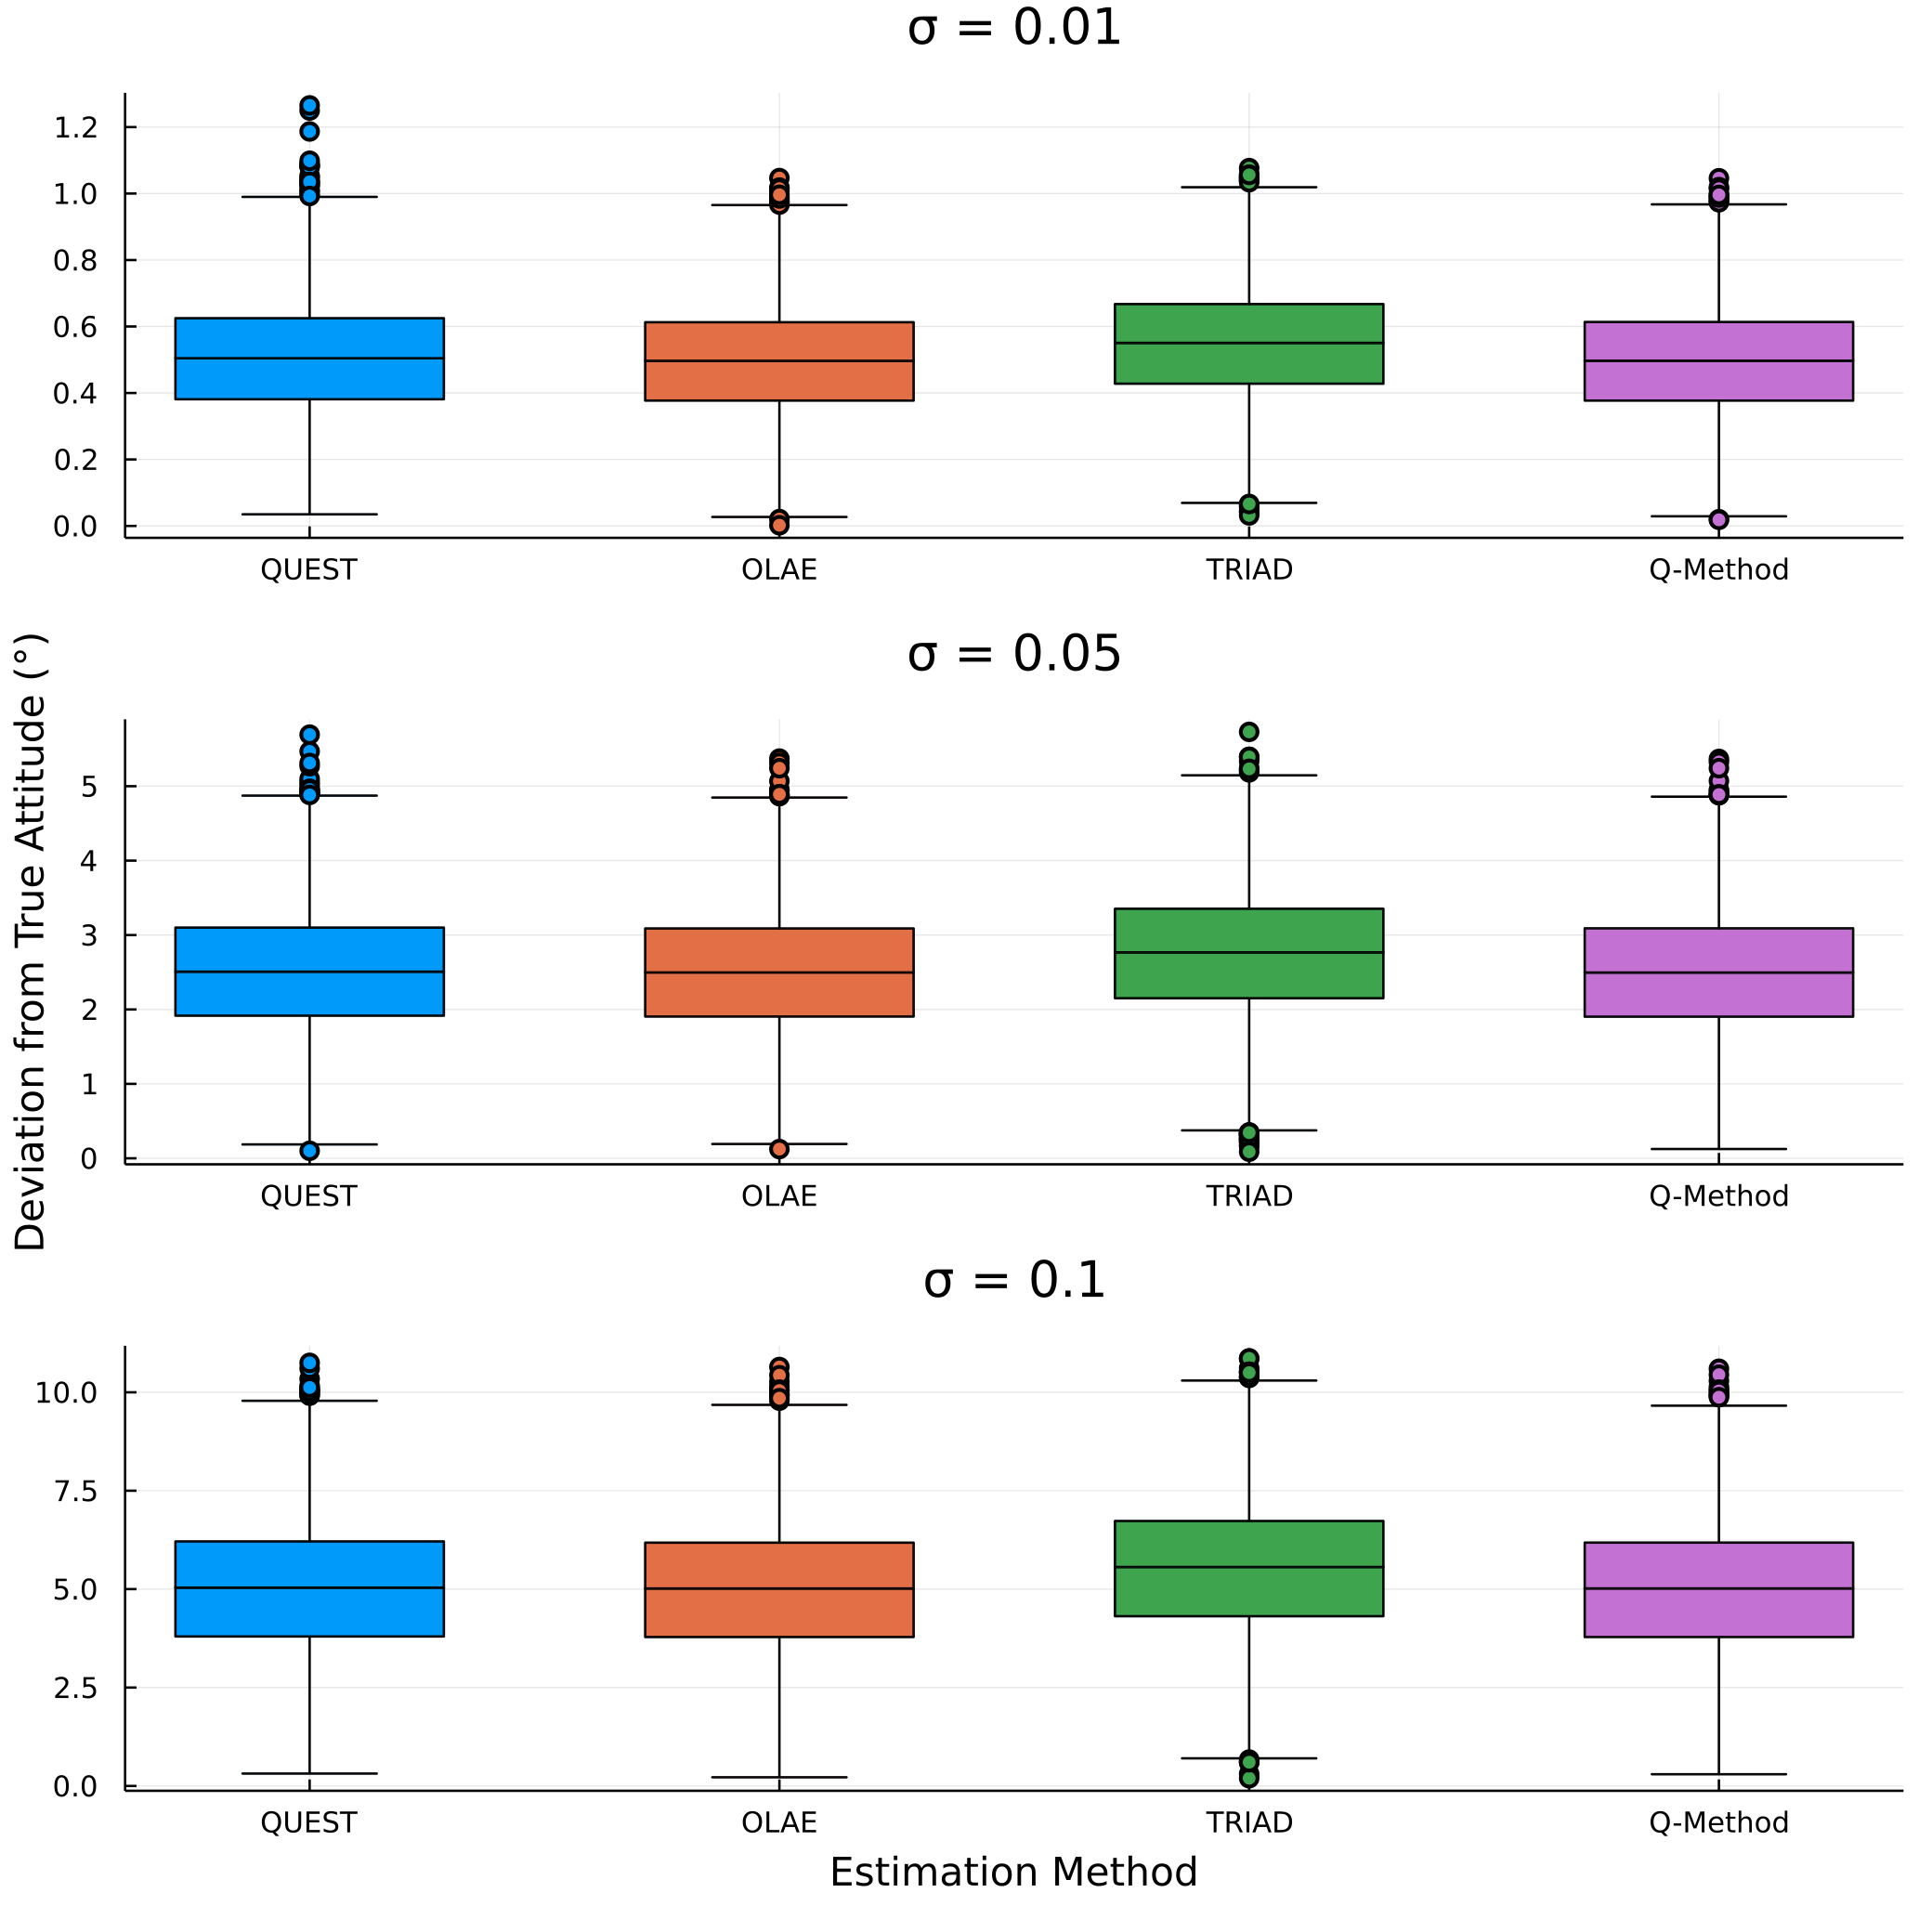

In [10]:
p1 = boxplot(
    ["QUEST"], q_dev[1],
    legend=nothing,
    title="σ = $(σs[1])"
)

boxplot!(["OLAE"], o_dev[1])
boxplot!(["TRIAD"], t_dev[1])
boxplot!(["Q-Method"], qm_dev[1])

p2 = boxplot(
    ["QUEST"], q_dev[2],
    legend=nothing,
    ylabel="Deviation from True Attitude (°)",
    title="σ = $(σs[2])"
)

boxplot!(["OLAE"], o_dev[2])
boxplot!(["TRIAD"], t_dev[2])
boxplot!(["Q-Method"], qm_dev[2])

p3 = boxplot(
    ["QUEST"], q_dev[3],
    legend=nothing,
    xlabel="Estimation Method",
    title="σ = $(σs[3])"
)

boxplot!(["OLAE"], o_dev[3])
boxplot!(["TRIAD"], t_dev[3])
boxplot!(["Q-Method"], qm_dev[3])

plot(p1, p2, p3, layout=(3,1), size=(800, 800), fmt=:png, dpi=260)

In [11]:
# statistical analysis
methods = ["QUEST", "OLAE", "TRIAD", "Q-Method"]
data = [q_dev, o_dev, t_dev, qm_dev]

stats = [
    [[], [], []],
    [[], [], []],
    [[], [], []],
    [[], [], []]
]

for (i,σ) in enumerate(σs)
    for (j, dev) in enumerate(data)
        println("$(round(mean(dev[i]), digits=6)) \t $(round(median(dev[i]), digits=6)) \t $(round(stdm(dev[i], mean(dev[i])), digits=6)) \t $(round(var(dev[i]), digits=6))")
        push!(stats[j][i], mean(dev[i]), median(dev[i]), stdm(dev[i], mean(dev[i])), var(dev[i]))
    end    
end

0.504134 	 0.50455 	 0.174228 	 0.030355
0.494794 	 0.49681 	 0.167348 	 0.028005
0.545101 	 0.550658 	 0.171257 	 0.029329
0.494641 	 0.49692 	 0.167266 	 0.027978
2.501166 	 2.507752 	 0.850885 	 0.724005
2.488747 	 2.498274 	 0.844357 	 0.712939
2.743174 	 2.767471 	 0.867353 	 0.752301
2.488454 	 2.496445 	 0.844549 	 0.713263
5.012587 	 5.037474 	 1.706919 	 2.913573
4.986669 	 5.016546 	 1.694585 	 2.87162
5.495492 	 5.562676 	 1.737619 	 3.01932
4.987261 	 5.017193 	 1.695248 	 2.873865


In [12]:
Float64.(reduce(hcat, [stats[i][1] for i in 1:length(stats)])')

4×4 Matrix{Float64}:
 0.504134  0.50455   0.174228  0.0303552
 0.494794  0.49681   0.167348  0.0280052
 0.545101  0.550658  0.171257  0.029329
 0.494641  0.49692   0.167266  0.0279779

## Benchmarking

In [79]:
function benchmark_method(method, method_q, nv1, nv2; σ=deg2rad(1), n_tests=1000)
    θ = deg2rad.([rand(0:30), rand(0:30), rand(0:30)])
    C_BN = par_1(θ[3]) * par_2(θ[2]) * par_3(θ[1])
    
    Bv1_true = C_BN * nv1
    Bv2_true = C_BN * nv2
    
    Bv1 = apply_noise(Bv1_true, σ)
    Bv2 = apply_noise(Bv2_true, σ)
    
    if method_q
        C_method = q2DCM(method(nv1, nv2, Bv1, Bv2))
    else
        C_method = method(nv1, nv2, Bv1, Bv2)
    end
    
    return nothing
end

benchmark_method (generic function with 1 method)

In [81]:
@benchmark benchmark_method(quest_method, true, nv1, nv2, n_tests=100000000)

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  10.200 μs …  9.136 ms  ┊ GC (min … max): 0.00% … 99.57%
 Time  (median):     14.400 μs              ┊ GC (median):    0.00%
 Time  (mean ± σ):   15.781 μs ± 91.294 μs  ┊ GC (mean ± σ):  5.76% ±  1.00%

    ▆▄█▅           ▃▁                                          
  ▂▅████▇▇▆▅▆▆▅▄▆▇▇██▆▆▆▄▅▅▆▄▅▄▃▄▄▂▃▃▃▂▃▃▂▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁ ▃
  10.2 μs         Histogram: frequency by time        26.1 μs <

 Memory estimate: 11.58 KiB, allocs estimate: 154.

In [82]:
@benchmark benchmark_method(olae_method, true, nv1, nv2, n_tests=100000000)

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  12.500 μs …  10.781 ms  ┊ GC (min … max):  0.00% … 99.17%
 Time  (median):     15.100 μs               ┊ GC (median):     0.00%
 Time  (mean ± σ):   18.662 μs ± 149.257 μs  ┊ GC (mean ± σ):  11.25% ±  1.40%

     ▅█▇▄▂                                                      
  ▁▂▆██████▆▆▅▄▅▄▄▄▄▄▄▃▄▃▃▃▃▃▃▂▂▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▂
  12.5 μs         Histogram: frequency by time         30.2 μs <

 Memory estimate: 16.89 KiB, allocs estimate: 252.

In [83]:
@benchmark benchmark_method(triad_method, false, nv1, nv2, n_tests=100000000)

BenchmarkTools.Trial: 10000 samples with 8 evaluations.
 Range (min … max):  3.388 μs … 926.325 μs  ┊ GC (min … max):  0.00% … 99.23%
 Time  (median):     3.825 μs               ┊ GC (median):     0.00%
 Time  (mean ± σ):   4.780 μs ±  20.961 μs  ┊ GC (mean ± σ):  10.68% ±  2.43%

   ▂▆██▅▇▂                                                     
  ▂███████▄▃▃▃▃▂▂▂▁▂▂▂▂▃▃▂▂▂▂▂▂▂▂▂▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁ ▂
  3.39 μs         Histogram: frequency by time        7.68 μs <

 Memory estimate: 5.30 KiB, allocs estimate: 83.

In [84]:
@benchmark benchmark_method(q_method, true, nv1, nv2, n_tests=100000000)

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  11.700 μs …  8.620 ms  ┊ GC (min … max): 0.00% … 99.54%
 Time  (median):     15.400 μs              ┊ GC (median):    0.00%
 Time  (mean ± σ):   17.092 μs ± 86.128 μs  ┊ GC (mean ± σ):  5.02% ±  1.00%

    ▄█▇▄                                                       
  ▁▆█████▆▃▅▅▅▆▆▆▇▅▆▅▅▅▅▅▄▄▃▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁ ▃
  11.7 μs         Histogram: frequency by time        28.7 μs <

 Memory estimate: 11.45 KiB, allocs estimate: 148.

# Testing 3-Axis Attitude Estimation Methodologies
The magnetometer chosen has three separate sensors built in, I want to investigate whether averaging out all of the readings between the sensors results in more accurate results.

In [87]:
n_tests = 10000
nv_12 = [Float64[], Float64[], Float64[]]
nv_23 = [Float64[], Float64[], Float64[]]
nv_13 = [Float64[], Float64[], Float64[]]
nv_av = [Float64[], Float64[], Float64[]]

nv1 = [1, 0, 0]
nv2 = [0, 1, 0]
nv3 = [0, 0, 1]

# noise factor, ±σ
#σ = deg2rad(1)
#σs = [deg2rad(0.1), deg2rad(1), deg2rad(5)]
σs = [0.01, 0.05, 0.1]

for (i, σ) in enumerate(σs)
    for test in 1:n_tests
        θi = deg2rad.([rand(Uniform(0, 30)), rand(Uniform(0, 30)), rand(Uniform(0, 30))])
        C_BNi = par_1(θi[3]) * par_2(θi[2]) * par_3(θi[1])

        Bv1i_true = C_BNi * nv1
        Bv2i_true = C_BNi * nv2
        Bv3i_true = C_BNi * nv3

        Bv1i = apply_noise(Bv1i_true, σ)
        Bv2i = apply_noise(Bv2i_true, σ)
        Bv3i = apply_noise(Bv3i_true, σ)
        
        c_12 = q2DCM(quest_method(nv1, nv2, Bv1i, Bv2i))
        c_23 = q2DCM(quest_method(nv2, nv3, Bv2i, Bv3i))
        c_13 = q2DCM(quest_method(nv1, nv3, Bv1i, Bv3i))
        c_av = (c_12 + c_23 + c_13) ./ 3
        
        ϕ12 = rad2deg(dcm_deviation(c_12, C_BNi))
        ϕ23 = rad2deg(dcm_deviation(c_23, C_BNi))
        ϕ13 = rad2deg(dcm_deviation(c_13, C_BNi))
        ϕav = rad2deg(dcm_deviation(c_av, C_BNi))

        push!(nv_12[i], ϕ12)
        push!(nv_23[i], ϕ23)
        push!(nv_13[i], ϕ13)
        push!(nv_av[i], ϕav)
    end
end

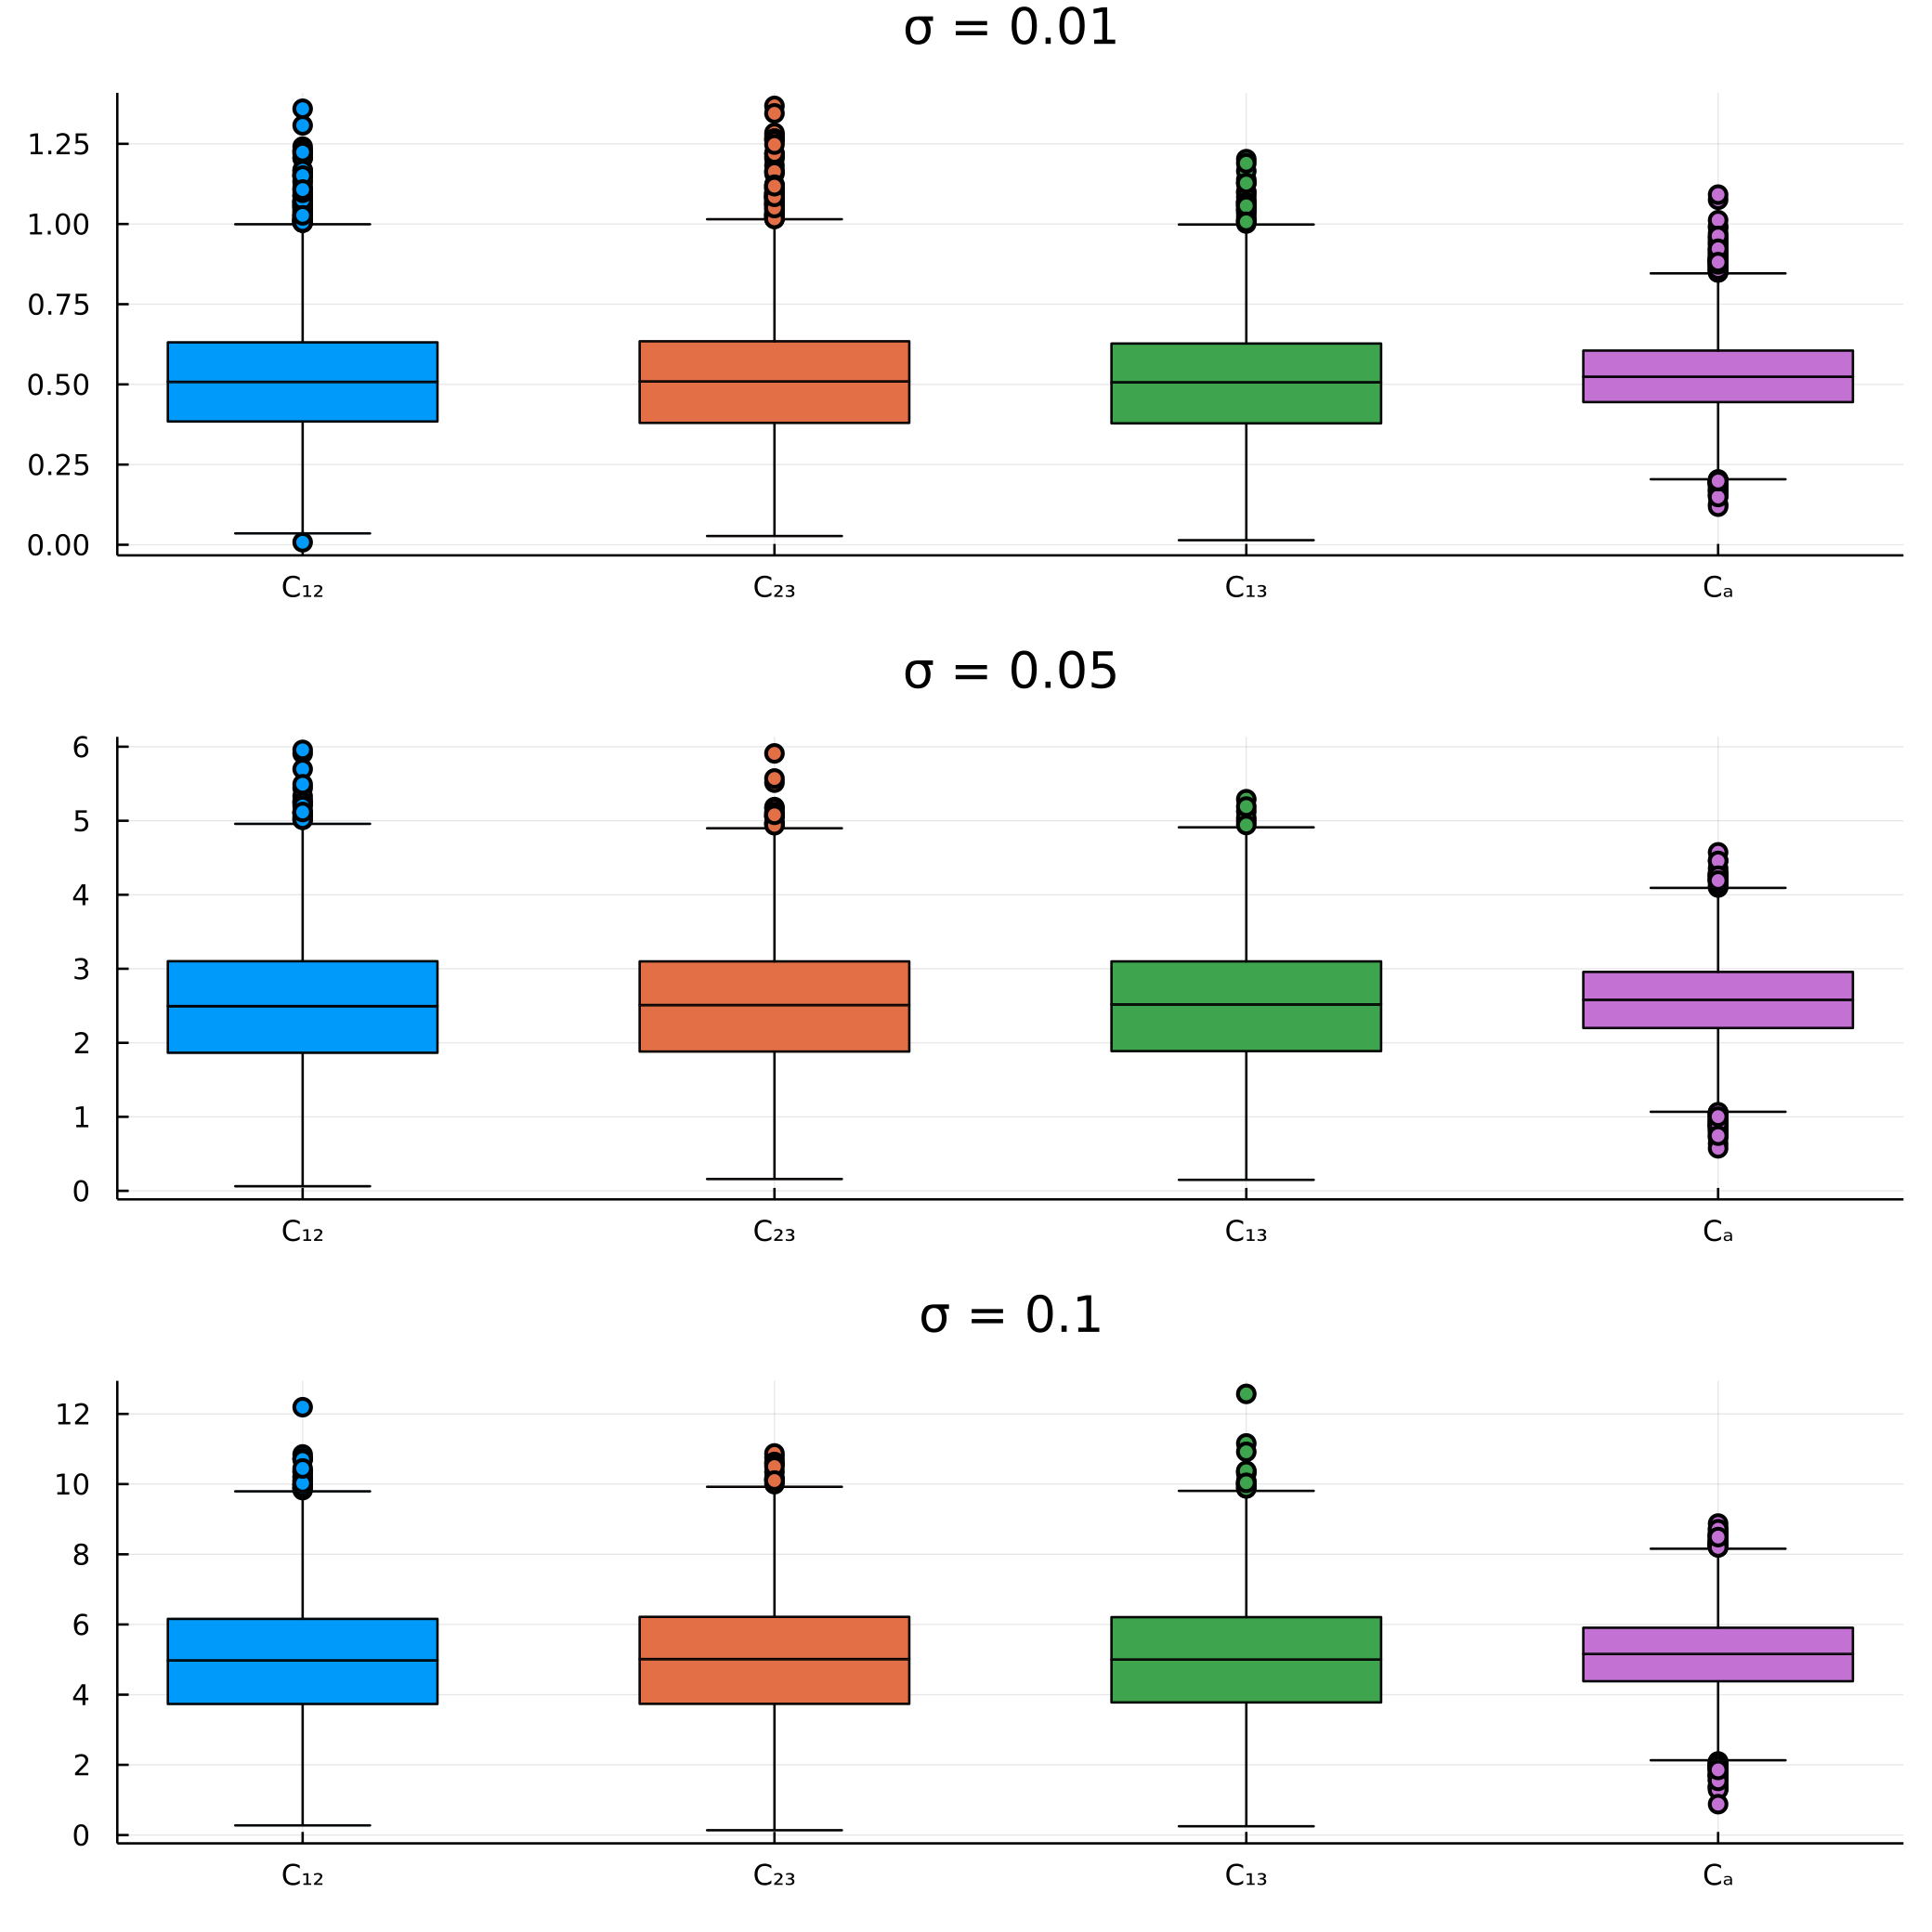

In [88]:
p1 = boxplot(
    ["C₁₂"], nv_12[1],
    legend=nothing,
    title="σ = $(σs[1])"
)

boxplot!(["C₂₃"], nv_23[1])
boxplot!(["C₁₃"], nv_13[1])
boxplot!(["Cₐ"], nv_av[1])

p2 = boxplot(
    ["C₁₂"], nv_12[2],
    legend=nothing,
    title="σ = $(σs[2])"
)

boxplot!(["C₂₃"], nv_23[2])
boxplot!(["C₁₃"], nv_13[2])
boxplot!(["Cₐ"], nv_av[2])

p3 = boxplot(
    ["C₁₂"], nv_12[3],
    legend=nothing,
    title="σ = $(σs[3])"
)

boxplot!(["C₂₃"], nv_23[3])
boxplot!(["C₁₃"], nv_13[3])
boxplot!(["Cₐ"], nv_av[3])

plot(p1, p2, p3, layout=(3,1), fmt=:png, dpi=260, size=(800, 800))

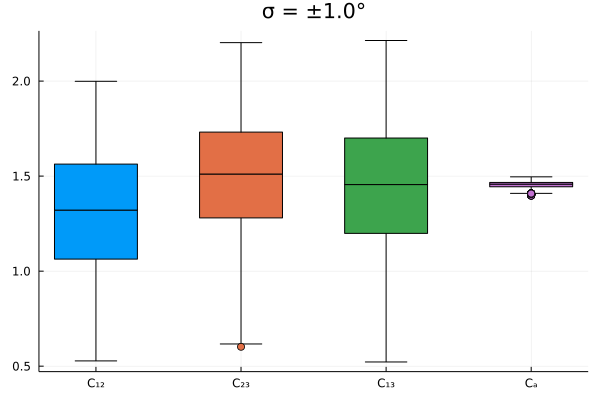

In [24]:
p2

# QUEST Iteration Number Testing

## Accuracy

In [13]:
n_tests = 1000
iters = [i for i in 1:10]
n_test_iterations = 10

nv1 = [1, 0, 0]
nv2 = [0, 0, 1]

σ_iter = 0.05

iter_testing_results = [[Float64[] for i in 1:length(iters)] for j in 1:n_test_iterations]
for j in 1:n_test_iterations
    for (i, iter) in enumerate(iters)
        for test in 1:n_tests
            θi = deg2rad.([rand(Uniform(0, 30)), rand(Uniform(0, 30)), rand(Uniform(0, 30))])
            C_BNi = par_1(θi[3]) * par_2(θi[2]) * par_3(θi[1])

            Bv1i_true = C_BNi * nv1
            Bv2i_true = C_BNi * nv2

            Bv1i = apply_noise(Bv1i_true, σ_iter)
            Bv2i = apply_noise(Bv2i_true, σ_iter)

            C_iter = q2DCM(quest_method(nv1, nv2, Bv1i, Bv2i, iter=iter))

            ϕq = rad2deg(dcm_deviation(C_iter, C_BNi))

            push!(iter_testing_results[j][i], ϕq)
        end
    end
end

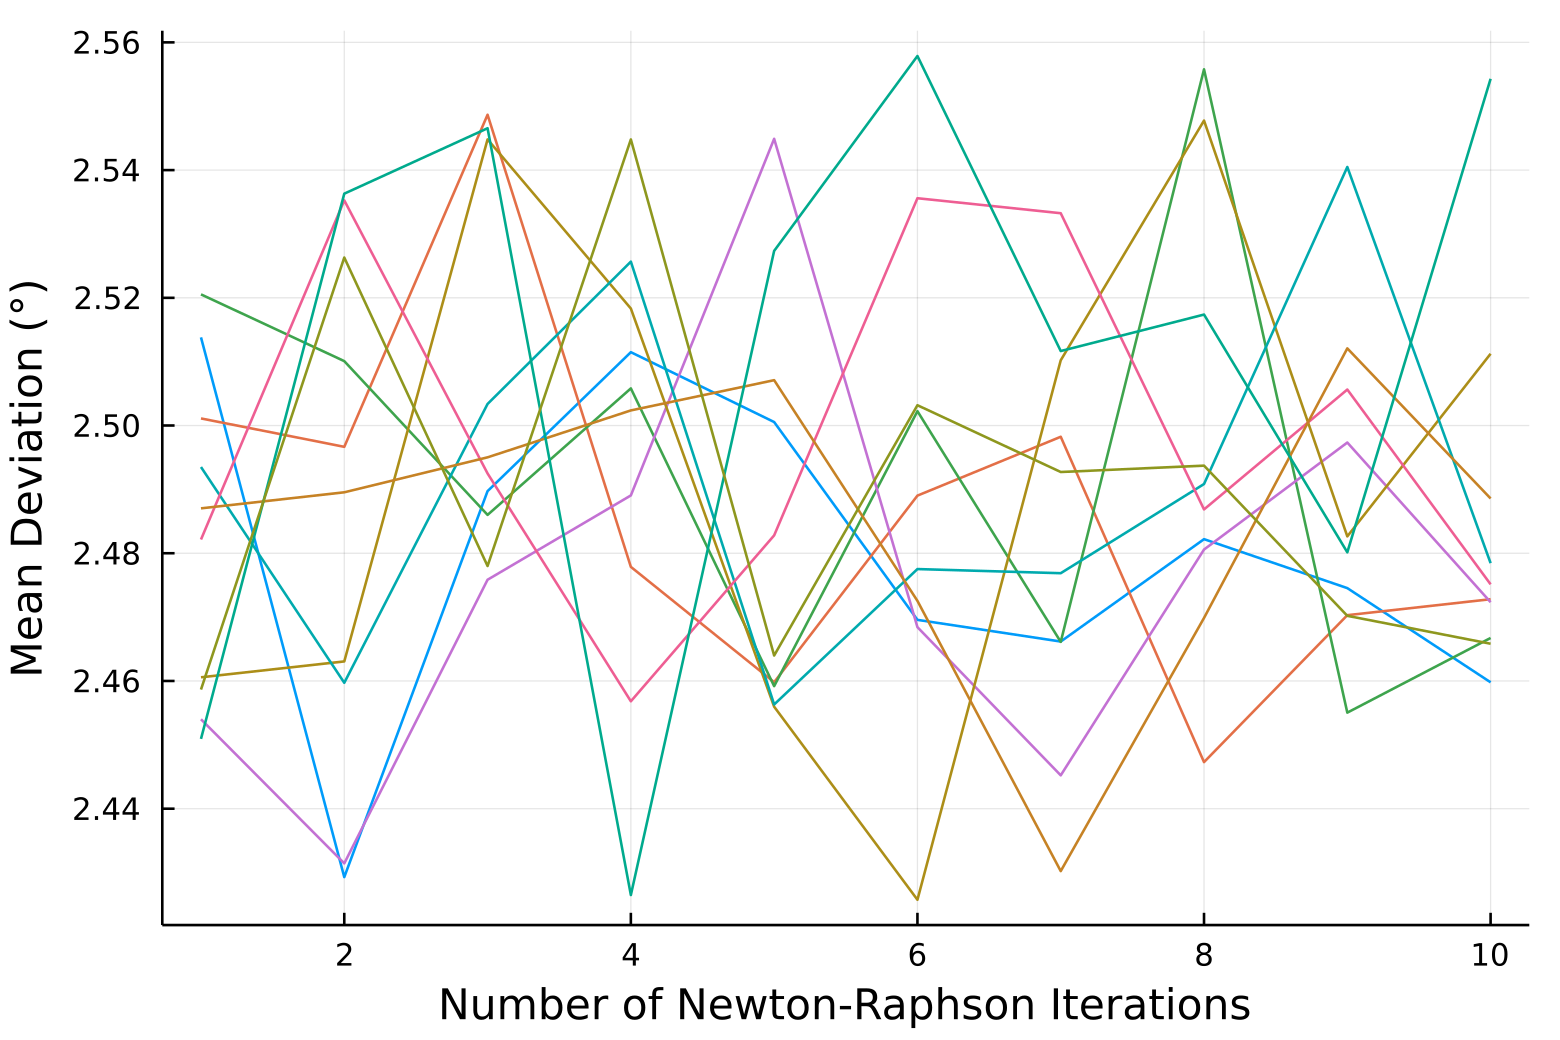

In [14]:
p = plot(
    iters, mean.(iter_testing_results[1]), 
    ylabel="Mean Deviation (°)", 
    xlabel="Number of Newton-Raphson Iterations", 
    label="",
    dpi=260,
    fmt=:png
)

for i in 2:n_test_iterations
    plot!(iters, mean.(iter_testing_results[i]), label="")
end

p

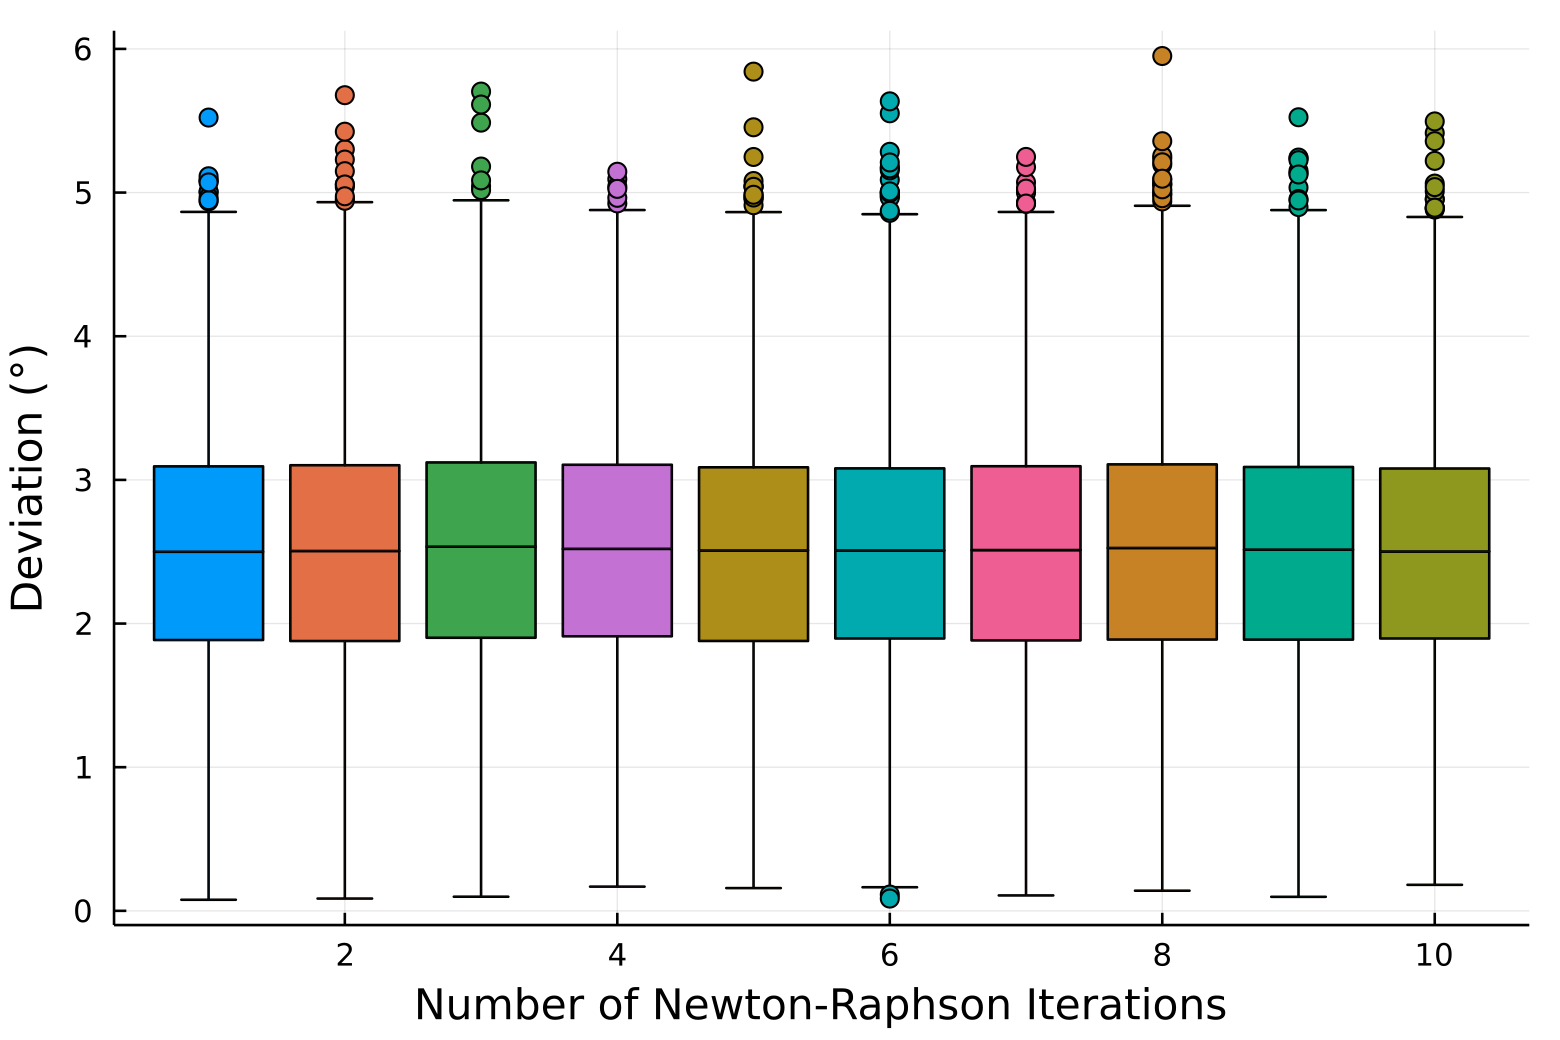

In [15]:
p = boxplot(
    reduce(vcat, [iter_testing_results[i][1] for i in 1:length(iter_testing_results)]), 
    label="",
    dpi=260,
    fmt=:png,
    ylabel="Deviation (°)",
    xlabel="Number of Newton-Raphson Iterations"
)

for j in 2:length(iter_testing_results[1])
   boxplot!(reduce(vcat, [iter_testing_results[i][j] for i in 1:length(iter_testing_results)]), label="") 
end

p

## Benchmarking

In [24]:
nv1 = [1, 0, 0]
nv2 = [0, 0, 1]

Bv1 = [0.8190, −0.5282, 0.2242]
Bv2 = [−0.3138, −0.1584, 0.9362];

t = @benchmark q2DCM(quest_method(nv1, nv2, Bv1, Bv2))

BenchmarkTools.Trial: 10000 samples with 5 evaluations.
 Range (min … max):  6.560 μs …  1.310 ms  ┊ GC (min … max): 0.00% … 98.89%
 Time  (median):     7.160 μs              ┊ GC (median):    0.00%
 Time  (mean ± σ):   8.603 μs ± 28.985 μs  ┊ GC (mean ± σ):  7.50% ±  2.21%

  ▁▄▇██▇▅▄▄▄▄▃▂▂▁   ▁▁▂▂▂▁▁▁▂▂▂▂▃▃▂▂▂▂▂▂▁▁ ▁                 ▂
  █████████████████████████████████████████████▇█▇▇▇▆▆▅▆▆▆▆▅ █
  6.56 μs      Histogram: log(frequency) by time     13.3 μs <

 Memory estimate: 7.28 KiB, allocs estimate: 82.

In [25]:
median(t.times)

7160.0

In [30]:
n_tests = 1
iters = [i for i in 1:10]
n_test_iterations = 10

nv1 = [1, 0, 0]
nv2 = [0, 0, 1]

σ_iter = 0.05

iter_testing_results_benchmark = [[Float64[] for i in 1:length(iters)] for j in 1:n_test_iterations]
for j in 1:n_test_iterations
    for (i, iter) in enumerate(iters)
        for test in 1:n_tests
            θi = deg2rad.([rand(Uniform(0, 30)), rand(Uniform(0, 30)), rand(Uniform(0, 30))])
            C_BNi = par_1(θi[3]) * par_2(θi[2]) * par_3(θi[1])

            Bv1i_true = C_BNi * nv1
            Bv2i_true = C_BNi * nv2

            Bv1i = apply_noise(Bv1i_true, σ_iter)
            Bv2i = apply_noise(Bv2i_true, σ_iter)

            t = @benchmark q2DCM(quest_method(nv1, nv2, $Bv1i, $Bv2i, iter=$iter))

            #ϕq = rad2deg(dcm_deviation(C_iter, C_BNi))

            push!(iter_testing_results_benchmark[j][i], median(t.times))

            println(IJulia.orig_stdout[], "Test Series $(j)/$(n_test_iterations) | Iter $(i)/$(length(iters)) | Test $test/$n_tests | $(median(t.times))")
        end
    end
end

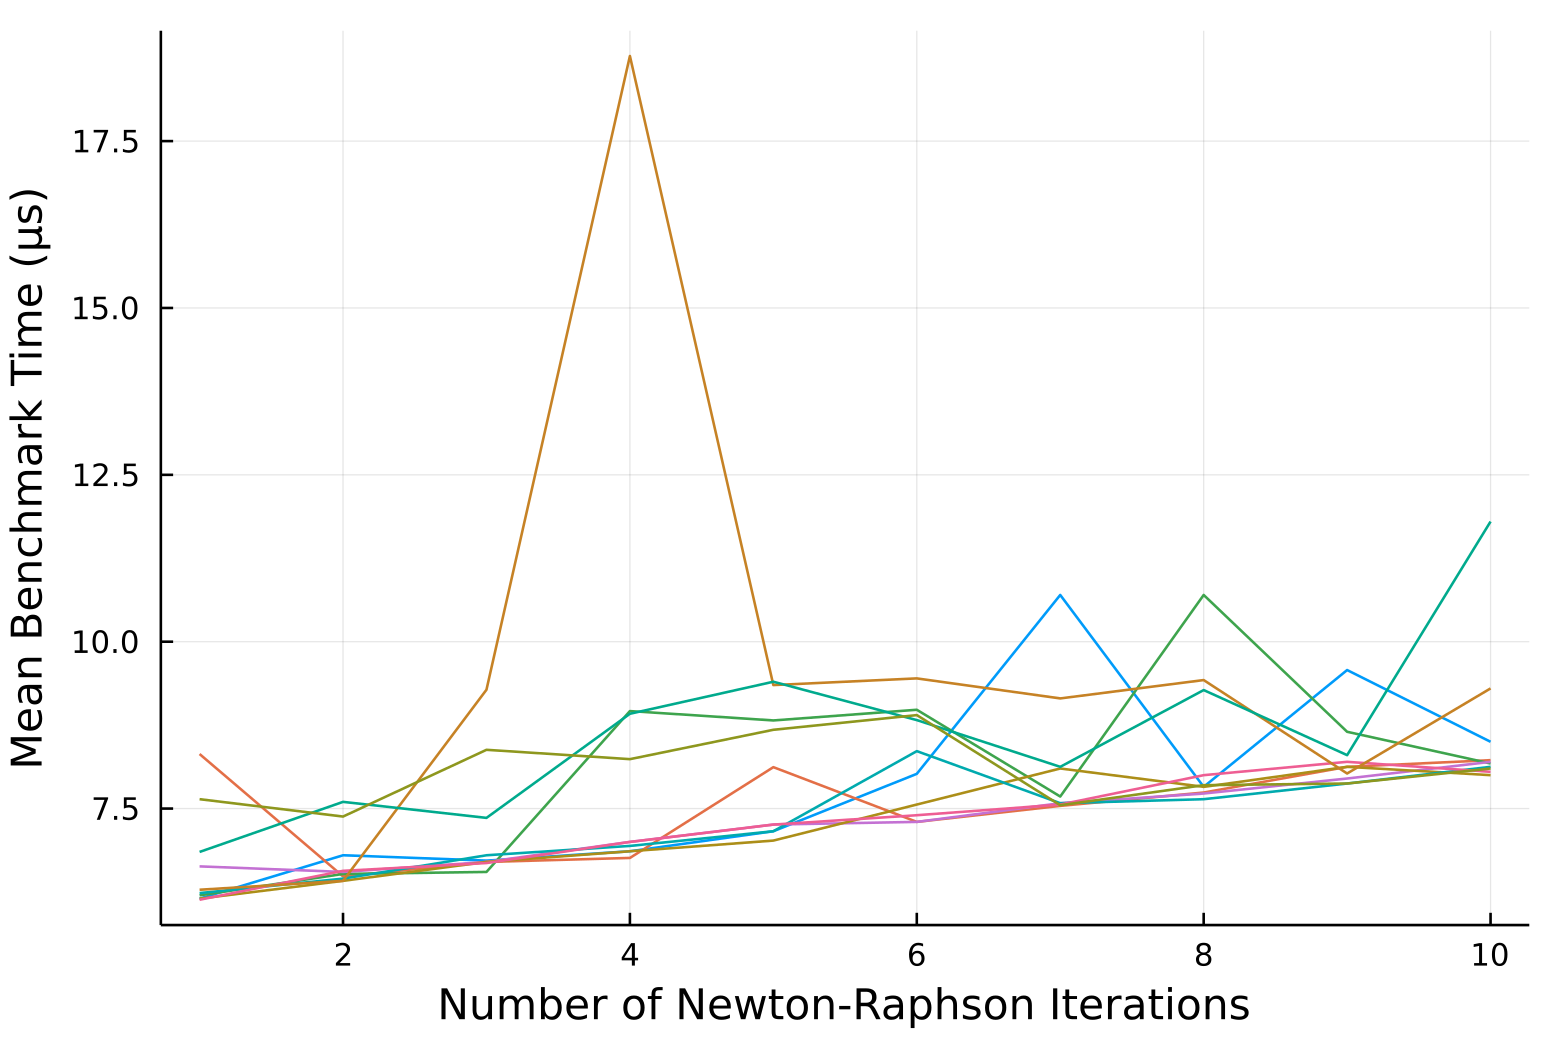

In [35]:
p = plot(
    iters, mean.(iter_testing_results_benchmark[1] ./ 1e3), 
    ylabel="Mean Benchmark Time (μs)", 
    xlabel="Number of Newton-Raphson Iterations", 
    label="",
    dpi=260,
    fmt=:png
)

for i in 2:n_test_iterations
    plot!(iters, mean.(iter_testing_results_benchmark[i] ./ 1e3), label="")
end

p

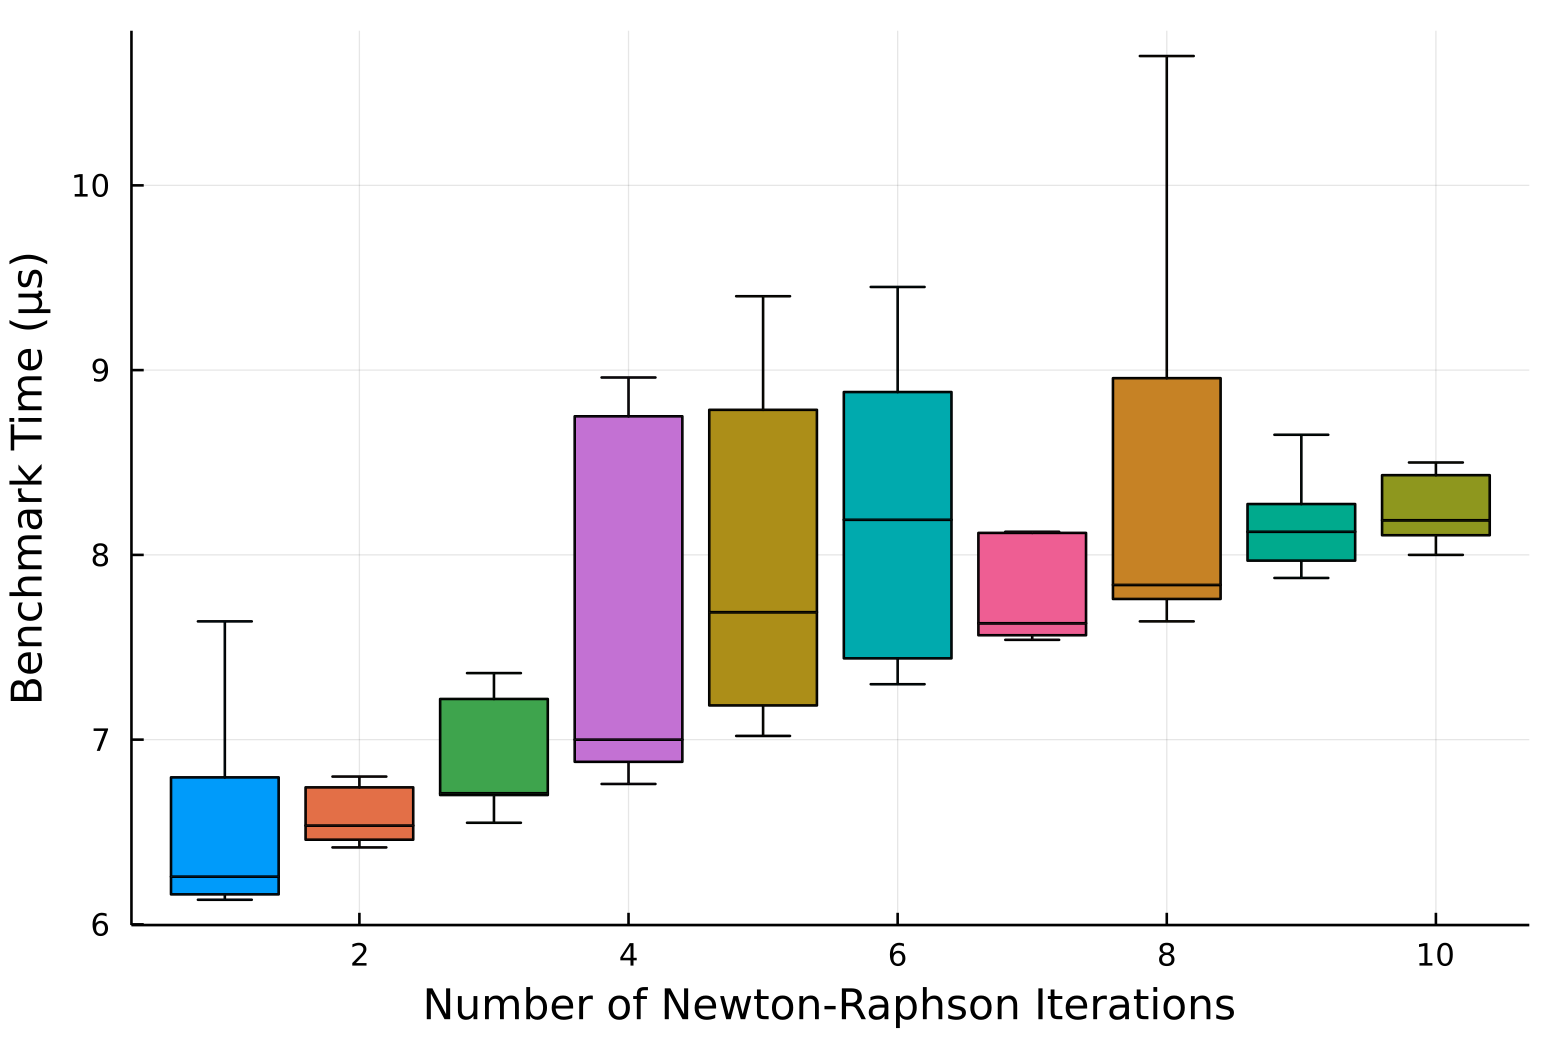

In [41]:
p = boxplot(
    reduce(vcat, [iter_testing_results_benchmark[i][1]./1e3 for i in 1:length(iter_testing_results_benchmark)]), 
    label="",
    dpi=260,
    fmt=:png,
    ylabel="Benchmark Time (μs)",
    xlabel="Number of Newton-Raphson Iterations",
    outliers=false
)

for j in 2:length(iter_testing_results_benchmark[1])
   boxplot!(reduce(vcat, [iter_testing_results_benchmark[i][j]./1e3 for i in 1:length(iter_testing_results_benchmark)]), label="", outliers=false) 
end

p